In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
# Definisikan parameter augmentasi dan ukuran batch
BATCH_SIZE = 32
IMG_SIZE = 160

# Normalisasi data (opsional, karena ImageDataGenerator bisa melakukannya)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# --- CARA BENERIN ERRORNYA DI SINI ---
# Bikin ImageDataGenerator dengan resizing
# Kita resize dan normalisasi di dalam generator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rescale=1./255, # Normalisasi
    # Keras tidak memiliki layer resizing di ImageDataGenerator, jadi kita akan resize
    # saat training dengan layer preprocessing
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Gunakan .flow() untuk membuat dataset dari array NumPy
train_dataset = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_dataset = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

In [4]:
# --- TAMBAHAN: Ubah arsitektur model lu ---
# Tambahin layer Resizing di awal arsitektur model
# Ini cara paling efektif buat nge-handle resizing tanpa ngabisin memori
from tensorflow.keras.layers import Resizing

# Bikin model dasar MobileNetV2
IMG_SHAPE = (160, 160, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True

# Bikin layer baru yang diawali dengan Resizing
inputs = tf.keras.Input(shape=(32, 32, 3))
x = Resizing(160, 160)(inputs) # Layer Resizing di sini!
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Nilai 0.2 artinya 20% neuron akan diabaikan
outputs = layers.Dense(10)(x) # 10 kelas untuk CIFAR-10
model = tf.keras.Model(inputs, outputs)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [5]:
# Asumsikan 'model' adalah objek model yang udah kamu buat sebelumnya
# Asumsikan 'train_dataset' dan 'validation_dataset' sudah siap

# Atur callbacks
# EarlyStopping buat nghentiin training kalo gak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ModelCheckpoint buat nyimpen bobot terbaik
checkpoint_path = '/content/drive/MyDrive/catVSdog_Model/cifar10_best_model.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Compile model
# Gunakan Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train model dan simpan history-nya
# Sesuaikan jumlah epochs sesuai kebutuhan
# Gw saranin mulai dari 10-20 epoch dulu
epochs = 20
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4178 - loss: 1.6863
Epoch 1: val_accuracy improved from -inf to 0.75100, saving model to /content/drive/MyDrive/catVSdog_Model/cifar10_best_model.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 168s 77ms/step - accuracy: 0.4179 - loss: 1.6860 - val_accuracy: 0.7510 - val_loss: 0.7273
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7367 - loss: 0.7735
Epoch 2: val_accuracy improved from 0.75100 to 0.84910, saving model to /content/drive/MyDrive/catVSdog_Model/cifar10_best_model.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.7367 - loss: 0.7735 - val_accuracy: 0.8491 - val_loss: 0.4485
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7905 - loss: 0.6075
Epoch 3: val_accuracy improved from 0.84910 to 0.88570, saving model to /content/drive/MyDrive/catVSdog_Model/cifar10_best_model.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.7905 - loss: 0

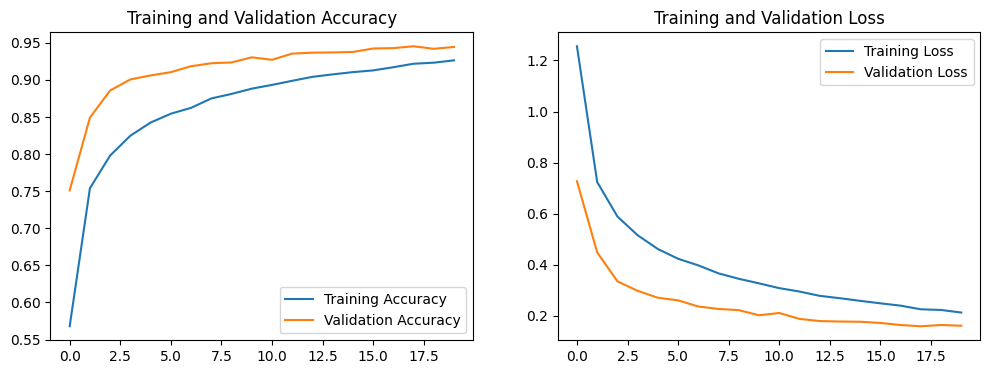

In [6]:
# Fungsi untuk plotting akurasi dan loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Panggil fungsi plot untuk melihat hasilnya
plot_history(history)

In [11]:
import os
from google.colab import drive
import tensorflow as tf

# Mount Google Drive ke folder baru, misalnya '/content/gdrive'
# Ini bakal ngindarin error kalo folder /content/drive ada isinya
try:
    drive.mount('/content/gdrive')
except ValueError as e:
    print(f"⚠️ Error: {e}")
    print("Mencoba me-mount ke lokasi lain...")
    drive.mount('/content/gdrive', force_remount=True)

# Setelah ini, lu bisa cek isi drive lu di '/content/gdrive/MyDrive'
# Misalnya:
# print(os.listdir('/content/gdrive/MyDrive/catVSdog_Model'))
# Definisikan path untuk menyimpan model lengkap


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/catVSdog_Model.

In [13]:
model_path = '/content/gdrive/My Drive/catVSdog_Model/cifar10_final_model.keras'

# Simpan model secara keseluruhan
# Asumsikan 'model' adalah objek model yang sudah dilatih
model.save(model_path)
print("✅ Model utuh berhasil disimpan di Google Drive.")

# --- Ini cara loading modelnya kalo lu mau pake lagi ---
loaded_model = tf.keras.models.load_model(model_path)
print("✅ Model berhasil dimuat kembali.")

✅ Model utuh berhasil disimpan di Google Drive.
✅ Model berhasil dimuat kembali.
